<a href="https://colab.research.google.com/github/claire-fang/cs182-final-project/blob/main/array_sorting/gpt2sort_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/My\ Drive/gpt2_sort'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

%cd $DRIVE_PATH

## The space in `My Drive` causes some issues, so make a symlink to avoid this.
SYM_PATH = '/content/gpt2_sort'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1qq_eRQ7sEnurJKWlZrToQexrkT_1JQJn/gpt2_sort


In [3]:
import numpy as np
import os
import random
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    GPT2Model
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# GPT-2 Sort Fine-tuning & Inference with Masked Loss
This notebook fine-tunes GPT-2 on a custom sort dataset, masks the prompt tokens in loss so the model only learns to predict the output list, and supports inference.

## Customized Dataset

In [4]:
class SortDataset(Dataset):
    """
    Each example has a prompt and an answer; inject an EOS after the prompt and another after the answer.
    """
    def __init__(self, file_path, tokenizer, max_length=128):
        with open(file_path, 'r') as f:
            text = f.read().strip()
        self.examples = text.split('\n\n')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        # Split into prompt and answer
        raw = self.examples[idx]             # e.g. "Input: [13, 4]\nOutput: [4, 13]"
        prompt, answer = raw.split('\n', 1)
        eos = self.tokenizer.eos_token

        # Inject EOS between prompt and answer, and at the end
        full = prompt + eos + answer + eos

        tok = self.tokenizer(
            full,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids':      tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

In [5]:
def sort_collate(batch):
    # 1) pull out lists of individual tensors
    input_ids_list     = [item['input_ids']     for item in batch]
    attention_mask_list= [item['attention_mask'] for item in batch]

    # 2) pad up to the longest in this batch
    input_ids     = pad_sequence(input_ids_list,     batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask= pad_sequence(attention_mask_list,batch_first=True, padding_value=0)

    # 3) clone for labels
    labels = input_ids.clone()

    # 4) mask out the prompt (everything up to and including the first EOS)
    eos_id = tokenizer.eos_token_id
    for i, seq in enumerate(input_ids):
        eos_positions = (seq == eos_id).nonzero(as_tuple=True)[0]
        if len(eos_positions)>0:
            prompt_end = eos_positions[0].item() + 1
        else:
            prompt_end = 0
        labels[i, :prompt_end] = -100

    # 5) mask out any padding positions
    labels[attention_mask == 0] = -100

    return {
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'labels':         labels
    }

## Generate Training Samples

In [6]:
def generate_random_arrays(num_examples=10000, max_arr_len=5, seed=123, weight=np.array([0.05, 0.05, 0.05, 0.05, 0.8])):
  random.seed(seed)
  length_num = map(int, weight * num_examples)
  examples = []
  for len, num in enumerate(length_num):
    for _ in range(num):
      arr = random.sample(range(100), len + 1)
      sorted_arr = sorted(arr)
      example = f"Input: {arr}\nOutput: {sorted_arr}"
      examples.append(example)
  # shuffle the ordering
  random.shuffle(examples)
  return examples
# generate_random_arrays(100)

In [7]:
# # You only need to run this once!
# samples = generate_random_arrays()

# with open("./sort_train_with_weight.txt", "w") as f:
#     f.write("\n\n".join(samples))

## Fine-Tuning GPT2

In [8]:
def train(train_file, model_name='gpt2', output_dir='result',
          batch_size=2, epochs=3, max_length=128, save_steps=500):
    os.makedirs(output_dir, exist_ok=True)
    global tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # Save tokenizer for inference BEFORE training
    tokenizer.save_pretrained(output_dir)
    # dataset
    ds = SortDataset(train_file, tokenizer, max_length)
    # model
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # training args
    args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        save_steps=save_steps,
        logging_steps=100,
        report_to='none'
    )
    # trainer
    trainer = Trainer(
        model=model,
        args=args,
        data_collator=sort_collate,
        train_dataset=ds
    )
    trainer.train()
    trainer.save_model()


In [9]:
# train('sort_train_with_weight.txt')

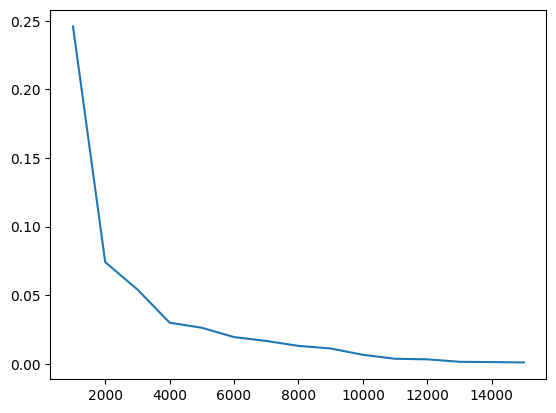

In [10]:
steps = np.arange(1000, 15001, 1000)
losses = [0.245800, 0.074000, 0.054100, 0.029900, 0.026200, 0.019400, 0.016600, 0.013000, 0.011100, 0.006500, 0.003600, 0.003200, 0.001400, 0.001200, 0.000900]
plt.plot(steps, losses)

## Inference
You can load our fine-tuned model if you don't want to train by *yourself*.

In [11]:
def infer(input_sequence: str,
          model_dir: str = 'result',
          max_new_tokens: int = 20):
    # 1) Load tokenizer & model
    tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token':'<|pad|>'})
    model = GPT2LMHeadModel.from_pretrained(model_dir)
    model.resize_token_embeddings(len(tokenizer))
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 2) Tokenize with attention mask
    enc = tokenizer(
        input_sequence,
        return_tensors='pt',
        padding=False,
        truncation=True,
        add_special_tokens=False
    )
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)

    # 3) Generate *only* max_new_tokens
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,    # ← switch to greedy
        num_beams=1,        # ← no beam search, just greedy
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # 4) Slice off the prompt tokens and decode only the new ones
    gen_tokens = outputs[0, input_ids.shape[-1]:]
    result = tokenizer.decode(gen_tokens, skip_special_tokens=True)
    result = result.lstrip()
    # print(result)
    return result

### Length-2 Array Sorting

In [12]:
# generate length "len" arrays
def inference_with_len(seed, len, num_samples=100):
  num_correct = 0
  random.seed(seed)
  for i in range(num_samples):
    lst = []
    input = "Input: ["
    for j in range(len):
      random_a = random.randint(0, 100)
      lst.append(random_a)
    # sort a, b, c with python library:
    sorted_lst = sorted(lst)
    input = "Input: " + str(lst) + "\nOutput:"
    # print(input)
    if infer(input) == f'{sorted_lst}':
      num_correct += 1
    if i % 10 == 0:
        print(i)
        print(f'Accuracy: {num_correct / (i+1)}')

  print(num_samples)
  print(f'Accuracy: {num_correct / num_samples}')

In [13]:
inference_with_len(12345, 2, 100)

0
Accuracy: 1.0
10
Accuracy: 1.0
20
Accuracy: 1.0
30
Accuracy: 1.0
40
Accuracy: 1.0
50
Accuracy: 1.0
60
Accuracy: 1.0
70
Accuracy: 1.0
80
Accuracy: 1.0
90
Accuracy: 1.0
100
Accuracy: 1.0


### Length-3 Array Sorting

In [14]:
inference_with_len(23456, 3, 100)

0
Accuracy: 1.0
10
Accuracy: 1.0
20
Accuracy: 1.0
30
Accuracy: 1.0
40
Accuracy: 1.0
50
Accuracy: 0.9803921568627451
60
Accuracy: 0.9836065573770492
70
Accuracy: 0.9859154929577465
80
Accuracy: 0.9876543209876543
90
Accuracy: 0.989010989010989
100
Accuracy: 0.99


### Length-4 Array Sorting

In [15]:
inference_with_len(34567, 4, 100)

0
Accuracy: 1.0
10
Accuracy: 1.0
20
Accuracy: 1.0
30
Accuracy: 1.0
40
Accuracy: 1.0
50
Accuracy: 0.9803921568627451
60
Accuracy: 0.9836065573770492
70
Accuracy: 0.971830985915493
80
Accuracy: 0.9753086419753086
90
Accuracy: 0.978021978021978
100
Accuracy: 0.98


### Length-5 Array Sorting

In [16]:
inference_with_len(45678, 5, 100)

0
Accuracy: 1.0
10
Accuracy: 1.0
20
Accuracy: 1.0
30
Accuracy: 1.0
40
Accuracy: 1.0
50
Accuracy: 0.9803921568627451
60
Accuracy: 0.9836065573770492
70
Accuracy: 0.9859154929577465
80
Accuracy: 0.9753086419753086
90
Accuracy: 0.9560439560439561
100
Accuracy: 0.95


### Length-6 Array Sorting

In [17]:
inference_with_len(56789, 6, 100)

0
Accuracy: 1.0
10
Accuracy: 0.7272727272727273
20
Accuracy: 0.6190476190476191
30
Accuracy: 0.5806451612903226
40
Accuracy: 0.5121951219512195
50
Accuracy: 0.47058823529411764
60
Accuracy: 0.45901639344262296
70
Accuracy: 0.4225352112676056
80
Accuracy: 0.43209876543209874
90
Accuracy: 0.4725274725274725
100
Accuracy: 0.46


In [18]:
inference_with_len(56789, 7, 100)

0
Accuracy: 0.0
10
Accuracy: 0.5454545454545454
20
Accuracy: 0.7142857142857143
30
Accuracy: 0.6451612903225806
40
Accuracy: 0.6097560975609756
50
Accuracy: 0.5882352941176471
60
Accuracy: 0.5245901639344263
70
Accuracy: 0.5070422535211268
80
Accuracy: 0.5308641975308642
90
Accuracy: 0.5164835164835165
100
Accuracy: 0.5


## Linear Probing

In [19]:
# Load Fine-tuned result
tokenizer = GPT2Tokenizer.from_pretrained("result")
model = GPT2Model.from_pretrained("result", output_hidden_states=True)
model.eval()
for p in model.parameters():
    p.requires_grad = False

# Generate synthetic data
def generate_example():
    arr = random.sample(range(100), 5)
    sorted_arr = sorted(arr)
    return arr, [sorted_arr.index(x) for x in arr]  # arr, sorted_positions

# Get hidden states for number tokens
def extract_token_hidden_states(arr, labels):
    layer_dict = {}
    prompt = f"Input: {arr}\nOutput:"
    # Tokenize with attention mask
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inputs = tokenizer(prompt, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs) # perform a forward pass

    tokens = tokenizer.tokenize(prompt)
    token_ids = inputs['input_ids'][0].tolist()
    decoded_tokens = [tokenizer.decode([tok]) for tok in token_ids]

    for layer in range(13):
        hidden = outputs.hidden_states[layer][0]  # shape: [seq_len, hidden_dim]; use [0] since we only have one batch

        features = []
        final_labels = []

        for i, tok in enumerate(decoded_tokens):
            try:
                # Only keep number tokens (e.g. "3", "Ġ1", "Ġ4")
                val = int(tok.strip())
                if val in arr:
                    idx_in_arr = arr.index(val)
                    features.append(hidden[i].numpy()) # the hidden state correspinding to the ith element inside arr
                    final_labels.append(labels[idx_in_arr])
            except:
                continue
        layer_dict[layer] = (features, final_labels)

    return layer_dict

In [20]:
# Build dataset for each layer
samples = []
for _ in range(500):  # generate 500 samples
  samples.append(generate_example())

X_dict, y_dict = defaultdict(list), defaultdict(list)
for arr, labels in samples:
  layer_dict = extract_token_hidden_states(arr, labels)
  for layer in range(13):
    feats, labs = layer_dict[layer]
    X_dict[layer].extend(feats)
    y_dict[layer].extend(labs)

In [21]:
from sklearn import preprocessing

accs = []
y_pred_dict = {}
for layer in range(13):
  # Train linear probe
  # X_train, X_test, y_train, y_test = train_test_split(X_dict[layer], y_dict[layer], test_size=0.2)
  X_train, X_test, y_train, y_test = X_dict[layer][:1600], X_dict[layer][1600:], y_dict[layer][:1600], y_dict[layer][1600:]

  # standardization
  scaler_train = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler_train.transform(X_train)
  scaler_test = preprocessing.StandardScaler().fit(X_test)
  X_test = scaler_test.transform(X_test)

  clf = LogisticRegression(max_iter=1500)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # Evaluate
  acc = accuracy_score(y_test, y_pred)
  y_pred_dict[layer] = y_pred
  accs.append(acc)
  print(f"Linear probe accuracy for layer {layer}: {acc:.4f}")

Linear probe accuracy for layer 0: 0.4378
Linear probe accuracy for layer 1: 0.5200
Linear probe accuracy for layer 2: 0.5189
Linear probe accuracy for layer 3: 0.5178
Linear probe accuracy for layer 4: 0.5411
Linear probe accuracy for layer 5: 0.5489
Linear probe accuracy for layer 6: 0.5422
Linear probe accuracy for layer 7: 0.5478
Linear probe accuracy for layer 8: 0.5678
Linear probe accuracy for layer 9: 0.5711
Linear probe accuracy for layer 10: 0.5678
Linear probe accuracy for layer 11: 0.5611
Linear probe accuracy for layer 12: 0.5333


Text(0.5, 1.0, "Accuracy of predicting token position in sorted array using each layer's hidden states")

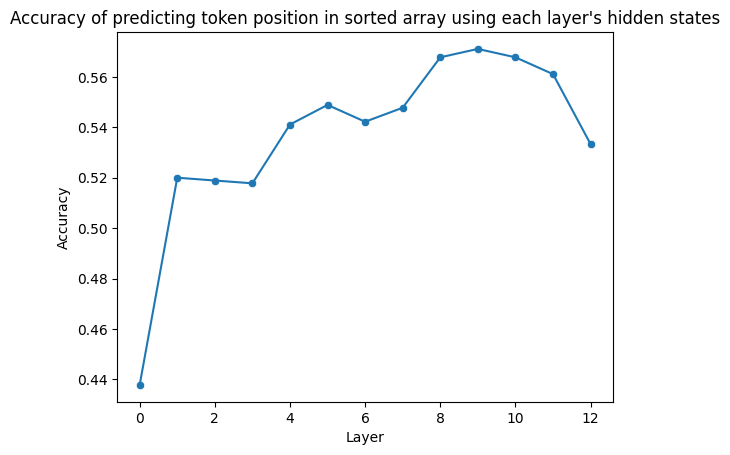

In [22]:
sns.scatterplot(x=list(range(13)), y=accs)
sns.lineplot(x=list(range(13)), y=accs)
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Accuracy of predicting token position in sorted array using each layer's hidden states")

## Setting up Tuned Lens

In [23]:
#@title Setup Environment for Tuned Lens
!git clone https://github.com/AlignmentResearch/tuned-lens.git
%cd tuned-lens
!pip install -e ".[dev]"
!pre-commit install
# 1) Re-pin torchdata to the last version with dataloader2
!pip install torchdata==0.8.0 --force-reinstall --no-deps

# 2) Install your cloned tuned-lens in editable mode, but don't install its dependencies
!pip install --no-deps -e /content/tuned-lens

# It's okay if it errors here as long as the later cells can run successfully.

fatal: destination path 'tuned-lens' already exists and is not an empty directory.
/content/gdrive/.shortcut-targets-by-id/1qq_eRQ7sEnurJKWlZrToQexrkT_1JQJn/gpt2_sort/tuned-lens
Obtaining file:///content/gdrive/.shortcut-targets-by-id/1qq_eRQ7sEnurJKWlZrToQexrkT_1JQJn/gpt2_sort/tuned-lens
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

pre-commit installed at .git/hooks/pre-commit
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: /content/tuned-lens is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [3]:
%cd /content/gdrive/MyDrive/gpt2_sort/tuned-lens

/content/gdrive/.shortcut-targets-by-id/1qq_eRQ7sEnurJKWlZrToQexrkT_1JQJn/gpt2_sort/tuned-lens


In [4]:
# @title Generate .jsonl file
# Generate .jsonl file to satisfy tuned lens format
import re, json

# 1) tighter bracket-only capture, allow multiline
pattern = re.compile(
    r"Input:\s*\[([^\]]*)\]\s*Output:\s*\[([^\]]*)\]",
    re.DOTALL | re.MULTILINE
)

# 2) load
with open("../sort_train_with_weight.txt", "r") as f:
    text = f.read()

# 3) debug print
# print("First 200 chars of file:\n", text[:200])
# print("Matches found:", len(pattern.findall(text)))

# 4) write JSONL
matches = list(pattern.finditer(text))
if matches:
    with open("sort_train_with_weight.jsonl", "w") as fout:
        for m in matches:
            # inp  = [int(x) for x in m.group(1).split(',') if x.strip()]
            # outp = [int(x) for x in m.group(2).split(',') if x.strip()]
            # fout.write(json.dumps({"input": inp, "output": outp}) + "\n")
            fout.write(json.dumps({"text": m.group(0)}) + "\n")
    print(f"Wrote {len(matches)} records to sort_train_with_weight.jsonl")
else:
    print("No Input/Output blocks found—nothing written.")


Wrote 10000 records to sort_train_with_weight.jsonl


In [5]:
# @title Check Torchdata Version
# Make sure the version is 0.8.0
import torchdata, tuned_lens
from torchdata import dataloader2
print("torchdata:", torchdata.__version__)
print("tuned_lens CLI ready!")

torchdata: 0.8.0+cpu
tuned_lens CLI ready!


/usr/local/lib/python3.11/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [26]:
!python -m tuned_lens train -h

2025-05-06 06:05:06.524359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746511506.557022    4888 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746511506.567465    4888 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
###############################################################

In [27]:
# @title Train Tuned Lens
# run this section only once; if you don't want to train, you can load our trained version
# !python -m tuned_lens train \
#   --model.name ../result \
#   --data.name sort_train_with_weight.jsonl \
#   --text_column text \
#   --per_gpu_batch_size 2 \
#   --tokens_per_step 1024 \
#   --num_steps 25 \
#   --output ../sorted-lens/gpt2-sort


In [28]:
# @title Load our Finetuned Model and Trained Tuned Lens
import torch
from tuned_lens.nn.lenses import TunedLens
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# To try a diffrent modle / lens check if the lens is avalible then modify this code
model_dir = '../result'
model = GPT2LMHeadModel.from_pretrained(model_dir)
model = model.to(device)

tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
lens_dir = '../sorted-lens/gpt2-sort'
tuned_lens = TunedLens.from_model_and_pretrained(model, lens_dir)
tuned_lens = tuned_lens.to(device)

In [29]:
# @title Setup Experiment samples
input_1 = tokenizer.encode(
    'Input: [6, 34, 11, 98, 52]\nOutput: [6, 11, 34, 52, 98]'
)
input_2 = tokenizer.encode(
    'Input: [34, 13, 4, 48, 68]\nOutput: [4, 13, 34, 48, 68]'
)
input_3 = tokenizer.encode(
    'Input: [71, 42, 43, 6, 20]\nOutput: [6, 20, 42, 43, 71]'
)
input_4 = tokenizer.encode(
    'Input: [31, 20, 0, 55, 99]\nOutput: [0, 20, 31, 55, 99]'
)
input_5 = tokenizer.encode(
    'Input: [60, 4, 98, 39, 17]\nOutput: [4, 17, 39, 60, 98]'
)
input_6 = tokenizer.encode(
    'Input: [16, 12, 92, 33, 80]\nOutput: [12, 16, 33, 80, 92]'
)

targets_1 = input_1[1:] + [tokenizer.eos_token_id]
targets_2 = input_2[1:] + [tokenizer.eos_token_id]
targets_3 = input_3[1:] + [tokenizer.eos_token_id]
targets_4 = input_4[1:] + [tokenizer.eos_token_id]
targets_5 = input_5[1:] + [tokenizer.eos_token_id]
targets_6 = input_6[1:] + [tokenizer.eos_token_id]
# targets_model = input_ids_model[1:] + [tokenizer.eos_token_id]

print(tokenizer.convert_ids_to_tokens(input_1))
# print the length of the tokens
print(len(input_1))
# print(tokenizer.convert_ids_to_tokens(input_ids_model))

['Input', ':', 'Ġ[', '6', ',', 'Ġ34', ',', 'Ġ11', ',', 'Ġ98', ',', 'Ġ52', ']', 'Ċ', 'Output', ':', 'Ġ[', '6', ',', 'Ġ11', ',', 'Ġ34', ',', 'Ġ52', ',', 'Ġ98', ']']
27


In [30]:
# generate length-5 arrays
def generate_tests(num_examples=10000, seed=123):
  random.seed(seed)
  examples = []
  for _ in range(num_examples):
    arr = random.sample(range(100), 5)
    sorted_arr = sorted(arr)
    example = f"Input: {arr}\nOutput: {sorted_arr}"
    examples.append(example)
  # shuffle the ordering
  random.shuffle(examples)
  return examples

def percentage_to_float(percentage_string):
  try:
      clean_string = percentage_string.strip().replace(",", ".")
      numeric_value = float(clean_string.replace("%", ""))
      return numeric_value / 100.0
  except ValueError:
      return None

test_samples = generate_tests(num_examples=100, seed=212)

In [31]:
# @title Setup Trajectories
from tuned_lens.plotting import PredictionTrajectory

line = slice(14, None)

def gen_tra(model, tokenizer, input_ids, targets):
  trajectory = PredictionTrajectory.from_lens_and_model(
      tuned_lens,
      model=model,
      tokenizer=tokenizer,
      input_ids=input_ids,
      targets=targets,
  ).slice_sequence(line)
  # print(trajectory.max_probability().trajectory_labels.hover_over_entries)
                            # shape: 13*13*10*2 = n_layers x sequence_length x n_hover_over_entries x cols
  return trajectory

def calculate_label_probs(model, test_samples):
  probs = np.zeros((13, 13, 100))
  for i in range(100):
    curr_sample = test_samples[i]
    input = tokenizer.encode(curr_sample)
    # input = torch.tensor(input, device=device)
    tokens = tokenizer.convert_ids_to_tokens(input)[14:]
    tokens = [token.replace("Ġ", "_") for token in tokens]
    # print(tokens)
    target = input[1:] + [tokenizer.eos_token_id]
    curr_trajectory = gen_tra(model, tokenizer, input, target)
    probabilities = curr_trajectory.max_probability().trajectory_labels.hover_over_entries
    for j in range(13):
      for k in range(13):
        label_prob = {probabilities[j][k][l][0]: probabilities[j][k][l][1] for l in range(10)}
        if k == 12:
          true_label = '<|endo…'
          # print([probabilities[j][k][l][0] for l in range(10)][0])
        else:
          true_label = tokens[k+1]
        true_prob = 0
        if true_label in label_prob.keys():
          true_prob = label_prob[true_label]
          true_prob = percentage_to_float(true_prob)
        # print(true_label, true_prob)
        probs[j][k][i] = true_prob
        # print(label_prob)

  probs = np.mean(probs, axis=2)
  probs = probs.tolist()
  return probs

# trajectory_1 = gen_tra(model, tokenizer, input_1, targets_1)
# trajectory_2 = gen_tra(model, tokenizer, input_2, targets_2)
# trajectory_3 = gen_tra(model, tokenizer, input_3, targets_3)
# trajectory_4 = gen_tra(model, tokenizer, input_4, targets_4)
# trajectory_5 = gen_tra(model, tokenizer, input_5, targets_5)
# trajectory_6 = gen_tra(model, tokenizer, input_6, targets_6)

In [32]:
avg_true_label_prob = calculate_label_probs(model, test_samples)
print(len(avg_true_label_prob))

13


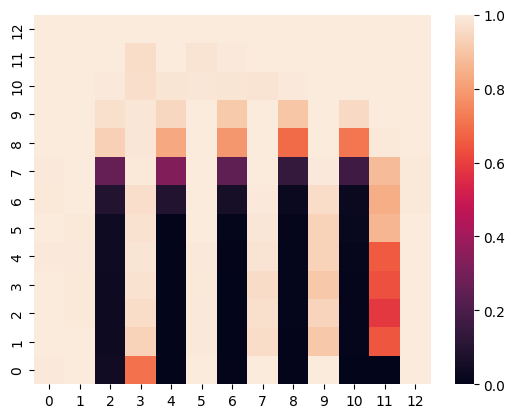

In [33]:
sns.heatmap(avg_true_label_prob)
plt.gca().invert_yaxis()

## Neuron Ablation

In [34]:
# @title Neuron Ablation

import copy

# def ablate_head(module, inp, out):
#     # out is a tuple, the first element is the attention output
#     out = list(out)  # Convert the tuple to a list to allow modification
#     out[0] = out[0].clone()  # Clone the first element (attention output)
#     out[0][..., start:end] = 0  # Apply ablation to the cloned tensor
#     return tuple(out)  # Convert the list back to a tuple

n_head = model.config.n_head                # 12 for gpt2-small
head_size = model.config.hidden_size // n_head

def calculate_ablated_prob(layer):
  ablated_prob_dict = {}

  model.eval()
  model.to(device)
  original_weights = model.transformer.h[layer].attn.c_attn.weight.data.clone() # Store original weights

  for h in range(n_head):
    start, end = h * head_size, (h + 1) * head_size

    # copy the model to model_ablated
    model_ablated = copy.deepcopy(model)

    # manually set the outputs the neurons of that head to be zero
    weights = model_ablated.transformer.h[layer].attn.c_attn.weight

    # Create a new tensor with the same data and requires_grad=False
    # This is a leaf variable, so we can change requires_grad
    new_weights = torch.tensor(weights.data, requires_grad=False, device=weights.device)

    # Apply ablation to the new_weights tensor
    new_weights[:, start:end] = 0

    # Assign the modified weights back to the model
    model_ablated.transformer.h[layer].attn.c_attn.weight = torch.nn.Parameter(new_weights)
    # print(h, "th head:")
    # print(model_ablated.transformer.h[layer_i].attn.c_attn.weight)

    avg_true_label_prob_ablated = calculate_label_probs(model_ablated, test_samples)
    ablated_prob_dict[h] = avg_true_label_prob_ablated

  return ablated_prob_dict


In [35]:
layer_to_ablated_probs = {}
for i in range(12): # not 13
  print("Calculating at the", i, "th layer:")
  ablated_prob_dict = calculate_ablated_prob(i)
  layer_to_ablated_probs[i] = ablated_prob_dict
  # store the results
  with open("../ablation_results.json", "w") as f:
    json.dump(layer_to_ablated_probs, f, indent=4)

Calculating at the 0 th layer:


<ipython-input-34-0ff80c956788>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_weights = torch.tensor(weights.data, requires_grad=False, device=weights.device)


Calculating at the 1 th layer:


KeyboardInterrupt: 

In [ ]:
layer_to_ablated_probs["no ablation"] = avg_true_label_prob
with open("../ablation_results.json", "w") as f:
  json.dump(layer_to_ablated_probs, f, indent=4)

### Pre-running Results
If you don't want to run your self, load our results!

In [ ]:
with open("ablation_results.json", "r") as f:
  data = json.load(f)

In [ ]:
# @title Plot Probability Changes (Each Graph Has a Different Scale)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import PowerNorm
# from matplotlib.colors import DivergingNorm
layer_to_ablated_probs = data
x_labels = [f"Token{i}" for i in range(13)]
y_labels = [f"Layer{i}" for i in range(12)] + ["Output"]

for i in range(12): # not 13
  fig, axes = plt.subplots(4, 3, figsize=(15, 12))
  fig.suptitle(f"Changes in Next Correct Token Prediction Probilities after Head Ablation at Layer {i}", fontsize=16)
  cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
  plt.tight_layout(rect=[0, 0, 1, 1])
  vmin = 100
  vmax = -100
  diff = []
  for j in range(12): # num of heads
    diff.append(np.array(layer_to_ablated_probs[str(i)][str(j)]) - np.array(layer_to_ablated_probs["no ablation"]))
    vmin = np.minimum(np.min(diff[j]), vmin)
    vmax = np.maximum(np.max(diff[j]), vmax)
    # print(vmin, vmax)


  for j in range(12): # num of heads
    plt_i, plt_j = j // 3, j % 3
    ax = axes[plt_i, plt_j]
    # sns.heatmap(diff[j], ax=ax, vmin=-0.35, vmax=0.1, cbar=(j == 0), cbar_ax=cbar_ax if j == 0 else None, cmap="coolwarm")
    # sns.heatmap(diff[j], ax=ax, cmap="coolwarm", norm=PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax), center=0, cbar=(j == 0), cbar_ax=cbar_ax if j == 0 else None)
    sns.heatmap(
    diff[j],
    ax=ax,
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax,
    center=0,          # ← this makes 0.0 map to the center color (white)
    cbar=(j == 0),
    cbar_ax=(cbar_ax if j == 0 else None),
    )

    # Add units to the colorbar
    if j == 0:
        cbar = ax.collections[0].colorbar
        cbar.set_label("Change in Probability")  # Set the colorbar label


    ax.set_title(f"Head {j} Ablated")
    ax.set_xticks(np.arange(len(x_labels)) + 0.5)
    ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=8)

    ax.set_yticks(np.arange(len(y_labels)) + 0.5)
    ax.set_yticklabels(y_labels, rotation=0, fontsize=8)
    ax.invert_yaxis()

  plt.tight_layout(rect=[0, 0, 0.9, 1])
  plt.show()